### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Data Load

In [2]:
# 파일 호출
data_path: str = "../../data"
#print(os.getcwd())
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 28.17it/s]


### EDA (Explanatory Data Analysis)

In [4]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_ftx_all_symbol_short_liquidations_usd     100.0
hourly_market-data_open-interest_bitmex_open_interest                     100.0
hourly_market-data_open-interest_all_exchange_open_interest               100.0
hourly_market-data_open-interest_gate_io_open_interest                    100.0
hourly_market-data_open-interest_deribit_open_interest                    100.0
                                                                          ...  
hourly_market-data_open-interest_htx_global_btc_usd_open_interest           0.0
hourly_network-data_transactions-count_transactions_count_total             0.0
target                                                                      0.0
ID                                                                          0.0
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest      0.0
Length: 255, dtype: float64

누락된 값이 60% 이상인 컬럼들은 제외한 후, numeric / categorical 피처로 분류한다.

In [5]:
essential_features = sorted_missing_percentage[sorted_missing_percentage<=40]

essential_eda_df = eda_df[essential_features.keys()]
cat_features = essential_eda_df.select_dtypes(include=["category"]).columns.tolist()
num_features = essential_eda_df.select_dtypes(exclude=["category"]).columns.tolist()

In [6]:
print("cat_features: ", cat_features)
print("num_features: ", num_features)

cat_features:  []
num_features:  ['hourly_market-data_open-interest_binance_btc_busd_open_interest', 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd', 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations', 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations', 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd', 'hourly_market-data_funding-rates_bybit_funding_rates', 'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio', 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume', 'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume', 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio', 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio', 'hourly_network-data_tokens-transferred_tokens_transferred_mean', 'hourly_network-data_block-bytes_block_bytes', 'hourly_network-data_transactions-count_transactions_count_mean', 'hourly_network-data_difficulty_difficul

In [7]:
essential_eda_df

,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,...,hourly_network-data_blockreward_blockreward,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_block-count_block_count,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_transactions-count_transactions_count_total,target,ID,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest
0,3.180371e+08,0.0,0.0,0.0,0.0,0.010000,0.411867,2015805.0,1411658.0,1.427970,...,75.561037,1.248565e+06,12.0,16536.747967,5516.420322,3.412540e+07,11457.0,2.0,2023-01-01 00:00:00,6.271344e+09
1,3.183281e+08,0.0,0.0,0.0,0.0,0.010000,0.225491,4032601.0,1174054.0,3.434766,...,25.256248,4.176322e+05,4.0,16557.136536,4513.341881,3.456750e+07,5832.0,1.0,2023-01-01 01:00:00,6.288683e+09
2,3.179729e+08,0.0,0.0,0.0,0.0,0.010000,0.635430,857595.0,1494750.0,0.573738,...,50.312978,8.321735e+05,8.0,16548.149805,4310.904314,3.452090e+07,5550.0,1.0,2023-01-01 02:00:00,6.286796e+09
3,3.179643e+08,0.0,0.0,0.0,0.0,0.010000,0.412550,1237990.0,869405.0,1.423951,...,31.469829,5.199754e+05,5.0,16533.632875,4893.417864,3.438940e+07,5245.0,1.0,2023-01-01 03:00:00,6.284575e+09
4,3.174773e+08,0.0,0.0,0.0,0.0,0.010000,0.537532,2423293.0,2816626.0,0.860353,...,44.094866,7.286038e+05,7.0,16524.712159,5209.002297,3.439200e+07,6942.0,2.0,2023-01-01 04:00:00,6.291582e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NaN,NaN,NaN,NaN,NaN,0.024847,0.604128,1987256.0,3032689.0,0.655279,...,76.618081,3.265909e+06,9.0,42597.709522,1002.251559,4.921820e+07,41286.0,1.0,2023-12-31 19:00:00,1.054230e+10
8756,NaN,NaN,NaN,NaN,NaN,0.023523,0.400193,6270592.0,4183763.0,1.498792,...,33.530340,1.427679e+06,4.0,42535.570787,1070.042124,4.916770e+07,21585.0,1.0,2023-12-31 20:00:00,1.051484e+10
8757,NaN,NaN,NaN,NaN,NaN,0.022368,0.560964,2274012.0,2905550.0,0.782644,...,25.665014,1.093419e+06,3.0,42497.523419,1026.473547,4.914800e+07,13803.0,0.0,2023-12-31 21:00:00,1.048598e+10
8758,NaN,NaN,NaN,NaN,NaN,0.021547,0.724267,10934468.0,28721507.0,0.380707,...,17.758057,7.537248e+05,2.0,42257.026218,1715.192245,4.919720e+07,8070.0,2.0,2023-12-31 22:00:00,1.032844e+10


-> 데이터가 60% 이상 존재하는 피처들은 전부 numerical 피처임을 확인했다.

--------

### 네트워크 데이터
transaction fee와 block interval은 양의 관계를 가지고, fee와 difficulty는 꽤나 높은 양의 관계를 갖는다.
target과는 큰 영향이 없어보인다.

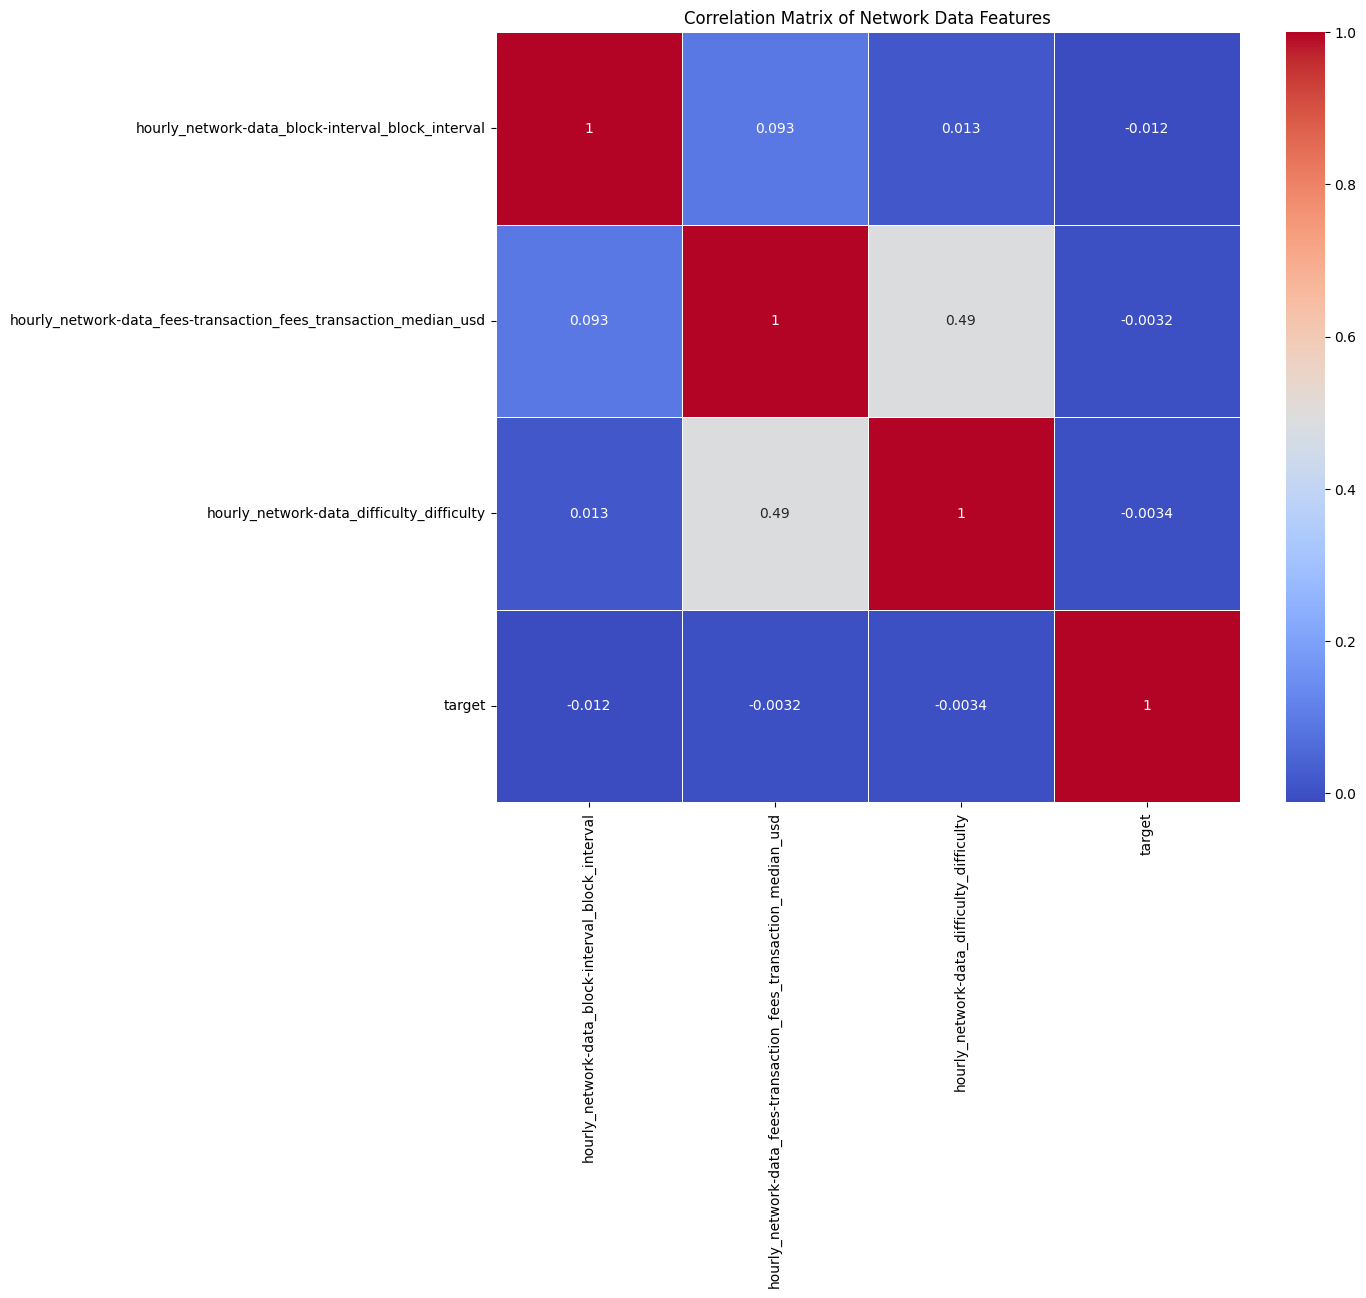

In [8]:
import seaborn as sns
# Network Data
# 유의미한 변수일 것으로 예상 되는 BLOCK-INTERVAL, FEES-TRANSACTION_USD와 target 간의 상관관계를 확인
plt.figure(figsize=(12,10))
correlation_matrix = essential_eda_df[['hourly_network-data_block-interval_block_interval', 'hourly_network-data_fees-transaction_fees_transaction_median_usd', 'hourly_network-data_difficulty_difficulty', 'target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Network Data Features')
plt.show()

## Feature Selection
- 상관계수, 단일변수 선택 기법으로 피처 간의 관계를 파악합니다.
- 시계열 데이터는 순서척도이므로 스피어먼 상관계수를 사용합니다.

In [25]:
network_columns = []
for col in essential_eda_df.columns:
    if 'network-data' in col:
        network_columns.append(col)

print(network_columns)

['hourly_network-data_tokens-transferred_tokens_transferred_mean', 'hourly_network-data_block-bytes_block_bytes', 'hourly_network-data_transactions-count_transactions_count_mean', 'hourly_network-data_difficulty_difficulty', 'hourly_network-data_fees_fees_block_mean_usd', 'hourly_network-data_fees_fees_block_mean', 'hourly_network-data_fees_fees_reward_percent', 'hourly_network-data_fees-transaction_fees_transaction_mean', 'hourly_network-data_fees-transaction_fees_transaction_mean_usd', 'hourly_network-data_block-interval_block_interval', 'hourly_network-data_utxo-count_utxo_count', 'hourly_network-data_fees_fees_total', 'hourly_network-data_fees_fees_total_usd', 'hourly_network-data_fees-transaction_fees_transaction_median_usd', 'hourly_network-data_addresses-count_addresses_count_active', 'hourly_network-data_addresses-count_addresses_count_sender', 'hourly_network-data_addresses-count_addresses_count_receiver', 'hourly_network-data_fees-transaction_fees_transaction_median', 'hourly

In [26]:
network_columns.append('target')
essential_eda_df[network_columns]

,hourly_network-data_tokens-transferred_tokens_transferred_mean,hourly_network-data_block-bytes_block_bytes,hourly_network-data_transactions-count_transactions_count_mean,hourly_network-data_difficulty_difficulty,hourly_network-data_fees_fees_block_mean_usd,hourly_network-data_fees_fees_block_mean,hourly_network-data_fees_fees_reward_percent,hourly_network-data_fees-transaction_fees_transaction_mean,hourly_network-data_fees-transaction_fees_transaction_mean_usd,hourly_network-data_block-interval_block_interval,...,hourly_network-data_tokens-transferred_tokens_transferred_median,hourly_network-data_velocity_velocity_supply_total,hourly_network-data_supply_supply_total,hourly_network-data_supply_supply_new,hourly_network-data_hashrate_hashrate,hourly_network-data_blockreward_blockreward,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_block-count_block_count,hourly_network-data_transactions-count_transactions_count_total,target
0,2.885312,7.835544e+05,954.750000,3.536407e+13,772.625301,0.046753,0.007425,0.000049,0.809244,427.333333,...,0.020125,65.978971,1.924871e+07,75.00,5.062917e+11,75.561037,1.248565e+06,12.0,11457.0,2.0
1,2.217758,8.907605e+05,1458.000000,3.536407e+13,1059.273848,0.064062,0.010146,0.000044,0.726525,782.500000,...,0.021293,65.977755,1.924874e+07,25.00,1.687639e+11,25.256248,4.176322e+05,4.0,5832.0,1.0
2,4.857703,5.582098e+05,693.750000,3.536407e+13,647.076754,0.039122,0.006221,0.000056,0.932723,365.125000,...,0.022980,65.975570,1.924879e+07,50.00,3.375278e+11,50.312978,8.321735e+05,8.0,5550.0,1.0
3,6.243646,6.403718e+05,1049.000000,3.536407e+13,726.437226,0.043966,0.006985,0.000042,0.692505,667.800000,...,0.024678,65.975092,1.924882e+07,31.25,2.109549e+11,31.469829,5.199754e+05,5.0,5245.0,1.0
4,3.824690,7.127390e+05,991.714286,3.536407e+13,814.168153,0.049267,0.007821,0.000050,0.820970,703.000000,...,0.028596,65.969825,1.924886e+07,43.75,2.953368e+11,44.094866,7.286038e+05,7.0,6942.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.845781,1.598697e+06,4587.333333,7.200615e+13,96466.654522,2.263120,0.265839,0.000493,21.028918,449.777778,...,0.000620,15.474537,1.958605e+07,56.25,7.731601e+11,76.618081,3.265909e+06,9.0,41286.0,1.0
8756,0.927301,1.684021e+06,5396.250000,7.200615e+13,90801.570252,2.132585,0.254407,0.000395,16.826791,691.750000,...,0.001052,15.474666,1.958607e+07,25.00,3.436267e+11,33.530340,1.427679e+06,4.0,21585.0,1.0
8757,1.001413,1.624134e+06,4601.000000,7.200615e+13,98195.518730,2.305005,0.269433,0.000501,21.342212,827.333333,...,0.005020,15.474537,1.958609e+07,18.75,2.577200e+11,25.665014,1.093419e+06,3.0,13803.0,0.0
8758,2.317127,1.547872e+06,4035.000000,7.200615e+13,111601.204635,2.629028,0.296094,0.000652,27.658291,2189.500000,...,0.009216,15.473021,1.958611e+07,12.50,1.718134e+11,17.758057,7.537248e+05,2.0,8070.0,2.0


In [27]:
# 상관계수 행렬로 변수간 상관관계 확인


corr_mat = essential_eda_df[network_columns].corr(method='spearman')
corr_mat['target'].sort_values(ascending = False)

target                                                              1.000000
hourly_network-data_tokens-transferred_tokens_transferred_median    0.015669
hourly_network-data_addresses-count_addresses_count_receiver        0.013960
hourly_network-data_tokens-transferred_tokens_transferred_mean      0.011647
hourly_network-data_addresses-count_addresses_count_active          0.009960
hourly_network-data_block-count_block_count                         0.008323
hourly_network-data_supply_supply_new                               0.008323
hourly_network-data_blockreward_blockreward                         0.007407
hourly_network-data_fees-transaction_fees_transaction_median        0.007316
hourly_network-data_hashrate_hashrate                               0.006291
hourly_network-data_fees-transaction_fees_transaction_mean          0.005849
hourly_network-data_addresses-count_addresses_count_sender          0.005552
hourly_network-data_tokens-transferred_tokens_transferred_total     0.004726

In [28]:
market_columns = []

for col in essential_eda_df.columns:
    if 'market-data' in col:
        market_columns.append(col)

market_columns.append('target')

In [29]:
essential_eda_df[market_columns]

,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,...,hourly_market-data_funding-rates_all_exchange_funding_rates,hourly_market-data_liquidations_binance_all_symbol_long_liquidations,hourly_market-data_liquidations_binance_all_symbol_short_liquidations,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,target
0,3.180371e+08,0.0,0.0,0.0,0.0,0.010000,0.411867,2015805.0,1411658.0,1.427970,...,0.005049,0.012000,0.000,1.975161e+02,0.00000,16536.747967,5516.420322,3.412540e+07,6.271344e+09,2.0
1,3.183281e+08,0.0,0.0,0.0,0.0,0.010000,0.225491,4032601.0,1174054.0,3.434766,...,0.005049,0.000000,0.712,0.000000e+00,11833.56104,16557.136536,4513.341881,3.456750e+07,6.288683e+09,1.0
2,3.179729e+08,0.0,0.0,0.0,0.0,0.010000,0.635430,857595.0,1494750.0,0.573738,...,0.005049,0.000000,0.000,0.000000e+00,0.00000,16548.149805,4310.904314,3.452090e+07,6.286796e+09,1.0
3,3.179643e+08,0.0,0.0,0.0,0.0,0.010000,0.412550,1237990.0,869405.0,1.423951,...,0.005067,0.593000,0.000,9.754769e+03,0.00000,16533.632875,4893.417864,3.438940e+07,6.284575e+09,1.0
4,3.174773e+08,0.0,0.0,0.0,0.0,0.010000,0.537532,2423293.0,2816626.0,0.860353,...,0.006210,0.361000,0.000,5.944437e+03,0.00000,16524.712159,5209.002297,3.439200e+07,6.291582e+09,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NaN,NaN,NaN,NaN,NaN,0.024847,0.604128,1987256.0,3032689.0,0.655279,...,0.036371,0.163000,0.014,6.924677e+03,600.62560,42597.709522,1002.251559,4.921820e+07,1.054230e+10,1.0
8756,NaN,NaN,NaN,NaN,NaN,0.023523,0.400193,6270592.0,4183763.0,1.498792,...,0.037233,7.347896,6.532,3.119033e+05,279693.16923,42535.570787,1070.042124,4.916770e+07,1.051484e+10,1.0
8757,NaN,NaN,NaN,NaN,NaN,0.022368,0.560964,2274012.0,2905550.0,0.782644,...,0.037761,0.122000,1.211,5.201684e+03,51776.92115,42497.523419,1026.473547,4.914800e+07,1.048598e+10,0.0
8758,NaN,NaN,NaN,NaN,NaN,0.021547,0.724267,10934468.0,28721507.0,0.380707,...,0.038020,37.213441,3.496,1.573892e+06,148758.33579,42257.026218,1715.192245,4.919720e+07,1.032844e+10,2.0


In [30]:
# 상관계수 행렬로 변수간 상관관계 확인
# 연속형 변수이므로 스피어먼 상관계수 사용

corr_mat = essential_eda_df[market_columns].corr(method='spearman')
corr_mat['target'].sort_values(ascending = False)

target                                                                       1.000000
hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio             0.061636
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio        0.060934
hourly_market-data_liquidations_binance_all_symbol_long_liquidations         0.052259
hourly_market-data_liquidations_binance_btc_usdt_long_liquidations           0.051815
                                                                               ...   
hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_ratio              -0.037354
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio   -0.060934
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio        -0.060934
hourly_market-data_taker-buy-sell-stats_binance_taker_buy_sell_ratio        -0.061636
hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio             -0.061636
Name: target, Length: 185, dtype: float64

## Feature Selection
- f_classif, SelectKBest를 활용해 상관계수가 높은 feature를 확인합니다.
- SelectKBest 모듈은 NaN값을 포함하면 안되므로, 임의로 median 값을 mapping합니다.

In [87]:
from sklearn.model_selection import train_test_split

eda_x_train, eda_x_val, eda_y_train, eda_y_val = train_test_split(essential_eda_df.drop(columns='target'), 
                                                                essential_eda_df['target'], test_size=0.2)
eda_x_train.drop(columns=['_type', 'ID'], inplace=True)
eda_x_val.drop(columns=['_type', 'ID'], inplace=True)

eda_x_train.fillna(eda_x_train.median(), inplace=True)
eda_x_val.fillna(eda_x_val.median(), inplace=True)
eda_y_train.fillna(eda_y_train.median(), inplace=True)

In [94]:
from sklearn.feature_selection import f_classif, SelectKBest

n_feature = 50
selector1 = SelectKBest(f_classif, k = n_feature)
x_train_sel = selector1.fit_transform(eda_x_train, eda_y_train)
x_valid_sel = selector1.transform(eda_x_val)

In [95]:
mask = selector1.get_support()
sel_k_features = eda_x_train.columns[mask]
sel_k_features

Index(['hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd',
       'hourly_market-data_open-interest_huobi_global_btc_usdt_open_interest',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd'

# EDA 결과
- network data : tokens-transferred, fee transaction
- market data : taker_buy_volume, taker_sell_volume(매수/매도 주문량)
- market data : liquidations (공매수/공매도 주문량)
- market data : open_interest (전체 페어, 즉 전체 시장에서의 롱 포지션 / 숏 포지션 수)


---
# Feature Engineering

- liquidation과 taker_volume 피처들은 전부 rolling feature로 24시간 단위로 축적한 피처 생성
- target [0,3] oversampling

In [10]:
train_df = df.loc[df["_type"] == "train"]

col = 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume'
pd.concat(
    [
        train_df[col],
        train_df[col].rolling(12).sum().rename(f"12hours"),
        train_df[col].rolling(24).sum().rename(f"24hours"),
        train_df[col].rolling(48).sum().rename(f"48hours")
    ], axis = 1).tail(20)

,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,12hours,24hours,48hours
8740,4046606.0,57801486.0,156202525.0,444054526.0
8741,3385882.0,47784677.0,156275011.0,442913726.0
8742,2652740.0,47269464.0,156718348.0,439224807.0
8743,17783110.0,62710917.0,171145183.0,445577776.0
8744,15942159.0,72129347.0,171613144.0,450959980.0
8745,22330043.0,91132756.0,184879697.0,463704572.0
8746,5706794.0,93849913.0,184548668.0,461747386.0
8747,4152953.0,94824235.0,182083138.0,453778352.0
8748,6604711.0,93640120.0,181430591.0,453987740.0
8749,4547105.0,95509878.0,182049810.0,450184852.0


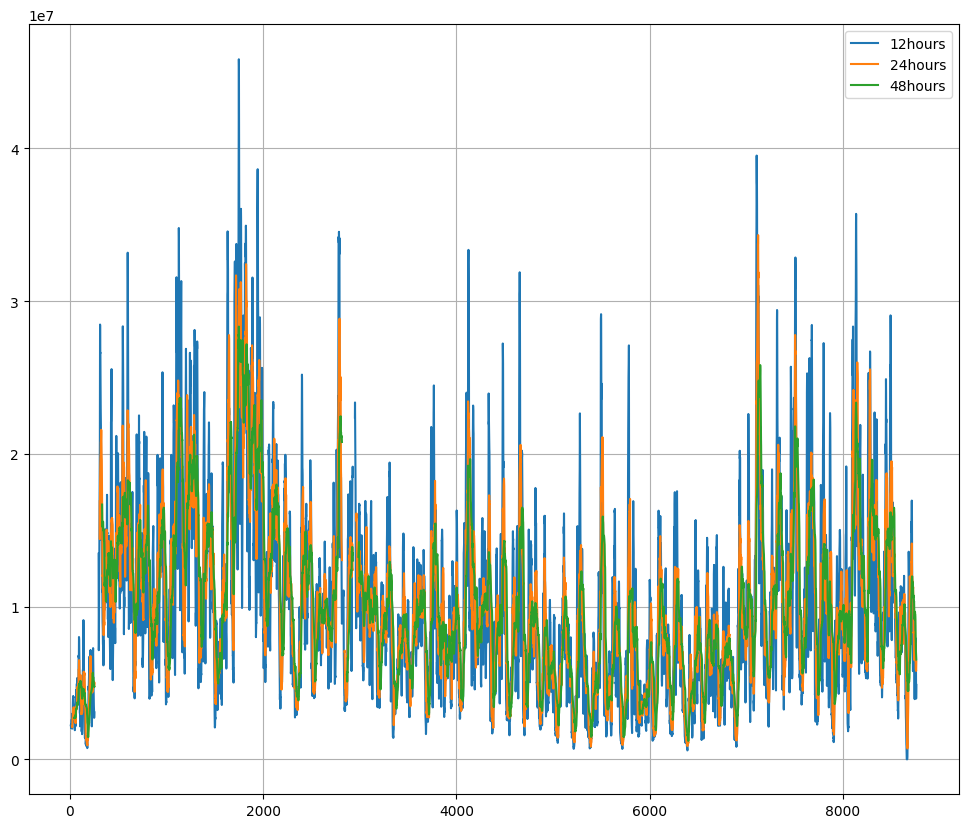

In [17]:
# 시각화
plt.figure(figsize = (12,10))
col = 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume'

for c in ['12hours', '24hours', '48hours']:
    plt.plot(
        pd.concat(
        [
            train_df[col],
            train_df[col].rolling(12).mean().rename(f"12hours"),
            train_df[col].rolling(24).mean().rename(f"24hours"),
            train_df[col].rolling(48).mean().rename(f"48hours")
        ], axis = 1)[c], label=str(c)
    )
plt.grid()
plt.legend()
plt.xticks()
plt.show()


=> 평균값으로 계산하면, width가 길수록 안정적이다. 중간값인 24시간으로 피처를 생성하도록 하겠다.

In [81]:
from typing import List
import pandas as pd

def rolling_feature(
   df: pd.DataFrame,
   conti_cols: List[str],
   intervals: List[int],
   funcs: List[str],
   min_periods: int,
   **params,
) -> pd.DataFrame:
   """
   Create rolling features
   Args:
       df (pd.DataFrame): Sorted dataframe
       conti_cols (List[str]): continuous colnames
       intervals (List[str]): rolling window widths
       funcs (List[str]): aggregation functions e.g. ["mean", "median", "max"]
       **params: more input for rolling
   Returns:
       pd.DataFrame
   """
   df_rolling_list = [
       df[conti_col]
       .rolling(interval, min_periods= min_periods, **params)
       .agg({f"{conti_col}": func})
       .rename({conti_col: f"{conti_col}_{func}_{interval}"}, axis=1)
       
       
       for conti_col in conti_cols
       for interval in intervals
       for func in funcs
   ]
   return pd.concat(df_rolling_list, axis=1)

In [84]:
# conti_cols : liquidation, taker_volume
# intervals : 24hours
# func : mean()

train_df = df.loc[df["_type"] == "train"]

conti_cols = [c for c in train_df.columns if 'volume' in c or 'liquidation' in c]
conti_cols = ['hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd','hourly_market-data_liquidations_bybit_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations',
        'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_short_liquidations']

intervals = [24]
funcs = ["mean"]

# 초기 데이터는 이전 값이 주어지지 않으므로, min_periods = 1로 설정해 NaN값을 방지한다.
rolling_df = rolling_feature(train_df, conti_cols, intervals, funcs, 1)
rolling_df

,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,3.772900e+05,2.525500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,4.205050e+05,1.847550e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,3.379333e+05,3.244767e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,2.975625e+05,2.932650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,2.640580e+05,3.101960e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,5.839264e+06,5.419129e+06,9.234767e+06,8.010475e+06,5.147249e+06,5.095539e+06,0.796875,33618.201433,1.158643,48646.770592,0.002275,96.000000,224062.051421,1.953375,82372.776391,5.228792
8756,5.828716e+06,5.312019e+06,9.279192e+06,7.966442e+06,5.157917e+06,5.077591e+06,0.736958,31135.888438,0.949888,39865.538900,0.002231,94.166667,235696.474302,1.702750,71940.482788,5.500500
8757,5.784857e+06,5.285992e+06,9.102867e+06,7.759250e+06,5.208412e+06,5.091745e+06,0.737083,31141.194500,0.949888,39865.538900,0.002231,94.166667,237853.846017,1.691542,71471.081911,5.550958
8758,6.115892e+06,6.234338e+06,9.409962e+06,8.428329e+06,5.266565e+06,5.111061e+06,0.883333,37347.457396,0.809456,34023.159713,0.002196,92.750000,244041.517126,3.035333,128359.242897,5.696375


In [85]:
train_df = pd.concat([train_df, rolling_df], axis=1)

## OverSampling
- SMOTE 기법을 적용해, 상대적으로 양이 적은 [0,3] 타겟의 데이터를 늘린다.

In [86]:
train_df['target'].value_counts()

target
2.0    3671
1.0    3544
3.0     805
0.0     740
Name: count, dtype: int64

In [87]:
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred",
    "hourly_network-data_fees-transaction_fees_transaction_median": "transaction_fee",
}

new_train_df = pd.concat([train_df[cols_dict.keys()].rename(cols_dict, axis=1), rolling_df], axis=1)
new_train_df

,ID,target,coinbase_premium_gap,tokens_transferred,transaction_fee,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,...,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,2023-01-01 00:00:00,2.0,-9.86,0.020125,0.000014,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,3.772900e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,2023-01-01 01:00:00,1.0,-8.78,0.021293,0.000014,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,4.205050e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,2023-01-01 02:00:00,1.0,-9.59,0.022980,0.000014,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,3.379333e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,2023-01-01 03:00:00,1.0,-9.74,0.024678,0.000014,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,2.975625e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,2023-01-01 04:00:00,2.0,-10.14,0.028596,0.000014,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,2.640580e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,1.0,-27.10,0.000620,0.000321,5.839264e+06,5.419129e+06,9.234767e+06,8.010475e+06,5.147249e+06,...,0.796875,33618.201433,1.158643,48646.770592,0.002275,96.000000,224062.051421,1.953375,82372.776391,5.228792
8756,2023-12-31 20:00:00,1.0,-24.73,0.001052,0.000292,5.828716e+06,5.312019e+06,9.279192e+06,7.966442e+06,5.157917e+06,...,0.736958,31135.888438,0.949888,39865.538900,0.002231,94.166667,235696.474302,1.702750,71940.482788,5.500500
8757,2023-12-31 21:00:00,0.0,-28.48,0.005020,0.000301,5.784857e+06,5.285992e+06,9.102867e+06,7.759250e+06,5.208412e+06,...,0.737083,31141.194500,0.949888,39865.538900,0.002231,94.166667,237853.846017,1.691542,71471.081911,5.550958
8758,2023-12-31 22:00:00,2.0,-9.08,0.009216,0.000350,6.115892e+06,6.234338e+06,9.409962e+06,8.428329e+06,5.266565e+06,...,0.883333,37347.457396,0.809456,34023.159713,0.002196,92.750000,244041.517126,3.035333,128359.242897,5.696375


In [88]:
x_train = new_train_df.drop(columns=['target','ID'])
y_train = new_train_df['target']

In [98]:
x_train['coinbase_premium_gap'].fillna(x_train['coinbase_premium_gap'].median(), inplace=True)
x_train[x_train.isna().any(axis=1)]

/tmp/ipykernel_311253/1078829136.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['coinbase_premium_gap'].fillna(x_train['coinbase_premium_gap'].median(), inplace=True)


,coinbase_premium_gap,tokens_transferred,transaction_fee,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24


In [102]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(sampling_strategy={0.0:1000, 3.0:1000})

new_x_train, new_y_train = sampler.fit_resample(x_train, y_train)

new_y_train.value_counts()

target
2.0    3671
1.0    3544
3.0    1000
0.0    1000
Name: count, dtype: int64

In [105]:
new_x_train

,coinbase_premium_gap,tokens_transferred,transaction_fee,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,-9.860000,0.020125,0.000014,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,3.772900e+05,2.525500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,-8.780000,0.021293,0.000014,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,4.205050e+05,1.847550e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,-9.590000,0.022980,0.000014,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,3.379333e+05,3.244767e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,-9.740000,0.024678,0.000014,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,2.975625e+05,2.932650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,-10.140000,0.028596,0.000014,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,2.640580e+05,3.101960e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,10.334167,0.014475,0.000028,1.187021e+07,1.004022e+07,7.506707e+06,7.623263e+06,4.234157e+06,4.277548e+06,1.572746,34461.683896,5.351434,115975.104156,0.009453,205.588562,133721.066109,2.617932,57550.013477,6.087311
9211,-20.195007,0.006039,0.000261,1.853054e+07,1.871715e+07,2.919475e+07,2.966431e+07,1.754096e+07,1.709733e+07,3.686856,151973.557622,6.363693,261333.550387,0.027997,1149.659809,404406.605297,6.729861,279214.157816,9.525149
9212,7.099788,0.015360,0.000304,1.549497e+07,1.645004e+07,1.752273e+07,1.689055e+07,1.282056e+07,1.138621e+07,1.453769,55821.381597,7.166053,286946.544149,0.015642,578.366088,325067.273477,3.832071,148885.234748,7.967784
9213,14.334082,0.001723,0.000118,1.171985e+07,1.113675e+07,1.540977e+07,1.547974e+07,1.297484e+07,1.452968e+07,1.524957,65770.497892,2.227371,95698.290752,0.006996,301.910233,271198.940374,4.351043,187688.042908,6.204203


In [122]:
### Model Training
from xgboost import XGBClassifier

# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    new_x_train, 
    new_y_train.astype(int), 
    test_size=0.2,
    random_state=42,
)

bst = XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, objective='multi:softmax', eval_metric=['merror','mlogloss'])

# train
bst.fit(x_train, y_train)

# predict
y_valid_pred = bst.predict(x_valid)
y_valid_proba = bst.predict_proba(x_valid)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred)
auroc = roc_auc_score(y_valid, y_valid_proba, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

# performance 체크후 전체 학습 데이터로 다시 재학습
#train_data = lgb.Dataset(new_x_train, label=new_y_train)
bst_model = bst.fit(
    new_x_train, new_y_train
)

acc: 0.38252848616386326, auroc: 0.6252404463656142
